<a href="https://colab.research.google.com/github/giakomorssi/Machine_Learning/blob/main/03_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import the Data

In [1]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd

# Change Colab runtime to GPU
import os
os.environ['COLAB_TPU_ADDR'] = ''
os.environ['COLAB_GPU_ALLOC'] = '1'
os.environ['COLAB_GPU'] = '1'
print("Runtime switched to GPU")

import tensorflow as tf

# This code sets the runtime to use the GPU if available
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

pd.set_option('display.max_columns', None)

Mounted at /content/drive
Runtime switched to GPU
Please install GPU version of TF


In [2]:
df = pd.read_csv('/content/drive/MyDrive/University/ML/customer_segmentation_RFM.csv')

In [3]:
df.head()

,order_id,customer_id,order_status,purchase_date,approved_date,handled_by_logistic_date,delivery_date,estimated_delivery_date,payment_type,payment_installments,payment_value,customer_unique_id,customer_city,customer_state,item_per_order,product_id,seller_id,shipping_limit_date,price,freight_value,seller_city,seller_state,product_category_name,product_name_lenght,product_description_lenght,product_category_name_english,purchase_approved_time,approved_handled_time,handled_delivery_time,delivery_estimated_time,recency,frequency,monetary
0,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,1,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,0,1,141.46,af07308b275d755c9edb36a90c618231,155.974000,149.392957,1,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,2018-07-30 03:24:27,118.7,22.76,88.027414,116.608786,122.827009,29,178,55,1842.83,666.55,17336.75,7712.25,35,1,141.46
1,86674ccaee19790309333210917b2c7d,1b338293f35549b5e480b9a3d7bbf3cd,1,2018-08-09 11:37:35,2018-08-09 14:35:19,2018-08-10 14:34:00,2018-08-14 18:51:47,2018-08-22,1,5,135.82,8b8028d453a01986b48c4271cc341475,131.450000,113.491669,1,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,2018-08-13 14:31:29,116.9,18.92,88.034259,116.608968,122.832287,29,178,55,177.73,1438.68,6017.78,10388.22,20,1,135.82
2,aee682982e18eb4714ce9f97b15af5e2,8858442ea4d5dc5bb9e118e8f728095d,1,2018-07-09 18:46:28,2018-07-11 03:45:45,2018-07-11 15:01:00,2018-07-12 18:14:35,2018-07-18,0,1,128.04,3edcab192482e9871c17b34cf98c3996,76.536923,125.816993,1,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,2018-07-13 03:45:45,118.7,9.34,88.027414,116.608786,122.827009,29,178,55,1979.28,675.25,1633.58,7545.42,25,2,254.27
3,f7f0b79050e7ef0b1cf7ffceb0aa114a,46fb8cff647939aaf32c4ab5be554501,1,2018-08-04 14:40:31,2018-08-07 04:44:36,2018-08-13 15:19:00,2018-08-14 15:08:57,2018-08-10,0,1,126.23,3edcab192482e9871c17b34cf98c3996,76.675385,125.818226,1,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,2018-08-09 04:44:36,116.9,9.33,88.034259,116.608968,122.832287,29,178,55,3724.08,9274.40,1429.95,-6668.95,25,2,254.27
4,d543201a9b42a1402ff97e65b439a48b,971bf8f42a9f8cb3ead257854905b454,1,2018-08-21 10:00:25,2018-08-21 10:50:54,2018-08-22 15:21:00,2018-08-28 18:58:22,2018-09-10,1,2,279.30,958ac7760e5484df1496ba5833ab6117,820.847500,146.354385,1,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,2018-08-23 10:50:54,116.9,22.75,88.034259,116.608968,122.832287,29,178,55,50.48,1710.10,8857.37,17581.63,8,1,558.60


In [4]:
df['purchase_date'] = pd.to_datetime(df['purchase_date'])
df['approved_date'] = pd.to_datetime(df['approved_date'])
df['handled_by_logistic_date'] = pd.to_datetime(df['handled_by_logistic_date'])
df['delivery_date'] = pd.to_datetime(df['delivery_date'])
df['estimated_delivery_date'] = pd.to_datetime(df['estimated_delivery_date'])
df['shipping_limit_date'] = pd.to_datetime(df['shipping_limit_date'])

# convert datetime column to numeric
df['purchase_date'] = df['purchase_date'].apply(lambda x: x.timestamp())
df['approved_date'] = df['approved_date'].apply(lambda x: x.timestamp())
df['handled_by_logistic_date'] = df['handled_by_logistic_date'].apply(lambda x: x.timestamp())
df['delivery_date'] = df['delivery_date'].apply(lambda x: x.timestamp())
df['estimated_delivery_date'] = df['estimated_delivery_date'].apply(lambda x: x.timestamp())
df['shipping_limit_date'] = df['shipping_limit_date'].apply(lambda x: x.timestamp())

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13718 entries, 0 to 13717
Data columns (total 33 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   order_id                       13718 non-null  object 
 1   customer_id                    13718 non-null  object 
 2   order_status                   13718 non-null  int64  
 3   purchase_date                  13718 non-null  float64
 4   approved_date                  13718 non-null  float64
 5   handled_by_logistic_date       13718 non-null  float64
 6   delivery_date                  13718 non-null  float64
 7   estimated_delivery_date        13718 non-null  float64
 8   payment_type                   13718 non-null  int64  
 9   payment_installments           13718 non-null  int64  
 10  payment_value                  13718 non-null  float64
 11  customer_unique_id             13718 non-null  object 
 12  customer_city                  13718 non-null 

# Standardize the Data

# Clustering

*   Identify the proper number of clusters, and evaluate different options.
*   Describe the properties of the clusters you have identified.
*   Describe the properties of the customers belonging to each cluster

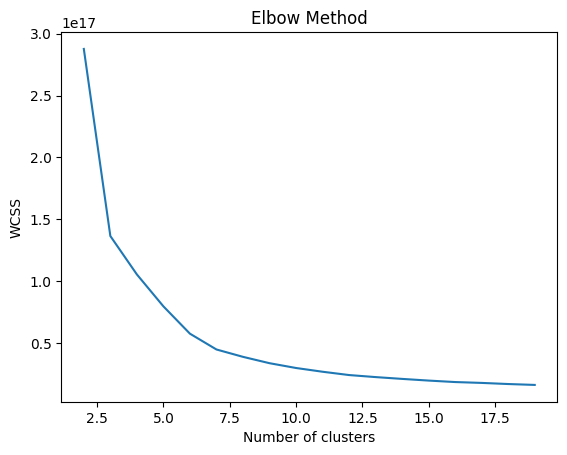

In [7]:
# Cluster the data
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
from matplotlib import pyplot as plt
import numpy as np

# drop customer_id, order_id, customer_unique_id, product_id, seller_id
X = df.drop(['customer_id', 'order_id', 'customer_unique_id', 'product_id', 'seller_id'], axis=1)

# Calculate within-cluster sum of squares for different values of k
wcss = []
for i in range(2, 20):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=500, n_init=10)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
    labels = kmeans.predict(X)

# Plot the elbow graph
plt.plot(range(2, 20), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

# Find the optimal value for k

In [9]:
!pip install kneed
from kneed import KneeLocator

# Find optimal k using elbow method
elbow = KneeLocator(range(2,20), wcss, curve='convex', direction='decreasing')
optimal_k = elbow.elbow + 1
print("Optimal k value:", optimal_k)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Optimal k value: 7


# Fit the KMeans model

In [ ]:
kmeans = KMeans(n_clusters=optimal_k, init='k-means++', max_iter=500, n_init=10)
kmeans.fit(X)

df['Cluster'] = kmeans.labels_
df['Cluster'].value_counts()

# Most Important Features

In [ ]:
# get cluster centers and feature names
cluster_centers = kmeans.cluster_centers_
feature_names = df.columns

# loop through each cluster center and print top 3 most important features
for i, center in enumerate(cluster_centers):
    top_features = sorted(zip(feature_names, center), key=lambda x: x[1], reverse=True)[:3]
    print(f"Top 3 features for cluster {i+1}: {top_features}")

# something

In [6]:
import seaborn as sns

clusters = kmeans.fit_predict(df)

# Visualize the clusters

# Create a scatter plot of the data, with points colored by cluster label
sns.scatterplot(data=df, x=df['frequency'], y=df['monetary'], hue=clusters, palette='deep', legend=None)

plt.title('Customer Segments') # Set the title of the plot
plt.show() # Show the plot

NameError: ignored